In [66]:
import re
import pandas as pd
import os
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import subprocess
import glob


In [67]:
def savefig(name, **kwargs):
    fn = "{}.eps".format(name)
    plt.savefig(fn, bbox_inches='tight')
    print("saving ", fn)

In [68]:
file_name_regex = re.compile(r'.*perf\.data\.([a-z_]+)_callee\.state(\d+)\.(\d+)\.(\d+)\.(\d+)')
callee_entry_regex = re.compile(r'^\s+\S+\s+\d+\s+\[\d+\]\s+(.+):\s+power:cpu_idle\:\s*state\=(\d+).+$')
caller_entry_regex = re.compile(r'^\s+cond_wait\s+\d+\s+\[\d+\]\s+(.+):\s+sched:sched_waking\:.+cpu=(\d+)$')

In [ ]:
df = pd.DataFrame()

for file_name in glob.glob('../test/data_txt/perf.data*'):
    print(f"Parsing {file_name}")

    result = file_name_regex.match(file_name)
    if result == None:
        continue

    locality, state, frequency, caller, callee = result.groups()
    state = int(state)
    frequency = int(frequency)
    caller = int(caller)
    callee = int(callee)
    folder = os.path.dirname(os.path.realpath(file_name))

    callee_file = folder + f"/perf.data.{locality}_callee.state{state}.{frequency}.{caller}.{callee}"
    callee_content=open(callee_file, 'r').read().splitlines()

    caller_file = folder + f"/perf.data.{locality}_caller.state{state}.{frequency}.{caller}.{callee}"
    caller_content=open(caller_file, 'r').read().splitlines()


    callee_times = []
    for line in callee_content:
        result = callee_entry_regex.match(line.rstrip())
        if result == None:
            continue

        time, _ = result.groups()
        time = float(time)

        callee_times.append(time)

    # print(callee_times)

    last_index=0
    latencies = []
    for line in caller_content:
        # parse the line
        result = caller_entry_regex.match(line)
        if result == None:
            continue

        caller_time, cpu = result.groups()
        cpu = int(cpu)
        caller_time = float(caller_time)

        if callee != cpu:
            continue

        # Find the time of first wakeup of the callee after the current current caller time
        for index in range(last_index, len(callee_times)):
            if callee_times[index] >= caller_time:
                last_index = index
                callee_time = callee_times[index]
                break

        latencies.append((callee_time-caller_time)*1000000)

    print(latencies)

    entires = []
    for latency in latencies:
        entires.append({
            'locality': locality,
            'state': state,
            'frequency': frequency,
            'caller': caller,
            'callee': callee,
            'wakeup latency us': latency
        })

    df = pd.concat([
        df,
        pd.DataFrame(entires)
    ])

df

Parsing ../test/data_txt/perf.data.performance_remote_active_caller.state3.1500000.1.57
Parsing ../test/data_txt/perf.data.performance_remote_active_callee.state3.1400000.1.57
[97.97300026548328, 98.38300002229516, 99.56899975804845, 100.81899972647079, 112.26000015085447, 104.14400003355695, 106.09599985400564, 98.04199999052798, 99.0989997262659, 100.98299981109449, 102.29899999103509, 103.93100001238054, 105.34700004427577, 96.26600012779818, 98.35699984250823, 151.4359996690473, 101.72500014959951, 103.16299994883593, 105.56000006545219, 107.75299961096607, 98.57600025497959, 100.43100019174744, 101.67199980060104, 103.64299987486447, 105.87600036160438, 97.75499984243652, 98.83699976853677, 100.98799975821748, 103.20699993826565, 105.03699968467117, 106.11499965307303, 98.0959998742037, 100.06299999076873, 101.10699986398686, 103.05699970558635, 105.3830001183087, 97.07400022307411, 98.3199997790507, 100.22599963122047, 101.37399976883898, 103.64500030846102, 104.74200007593026, 1

,locality,state,frequency,caller,callee,wakeup latency us
0,performance_remote_active,3,1400000,1,57,97.973
1,performance_remote_active,3,1400000,1,57,98.383
2,performance_remote_active,3,1400000,1,57,99.569
3,performance_remote_active,3,1400000,1,57,100.819
4,performance_remote_active,3,1400000,1,57,112.260
...,...,...,...,...,...,...
957,performance_remote_idle,3,1400000,1,57,124.089
958,performance_remote_idle,3,1400000,1,57,125.353
959,performance_remote_idle,3,1400000,1,57,137.408
960,performance_remote_idle,3,1400000,1,57,118.207


In [70]:
FREQUENCY = "Core Frequency [MHz]"
LATENCY = "Wakeup latency [us]"
MAX_CSTATE = "max cstate"
SETTING = "setting"

/home/marenz/de/tu-dresden/zih/roco2/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


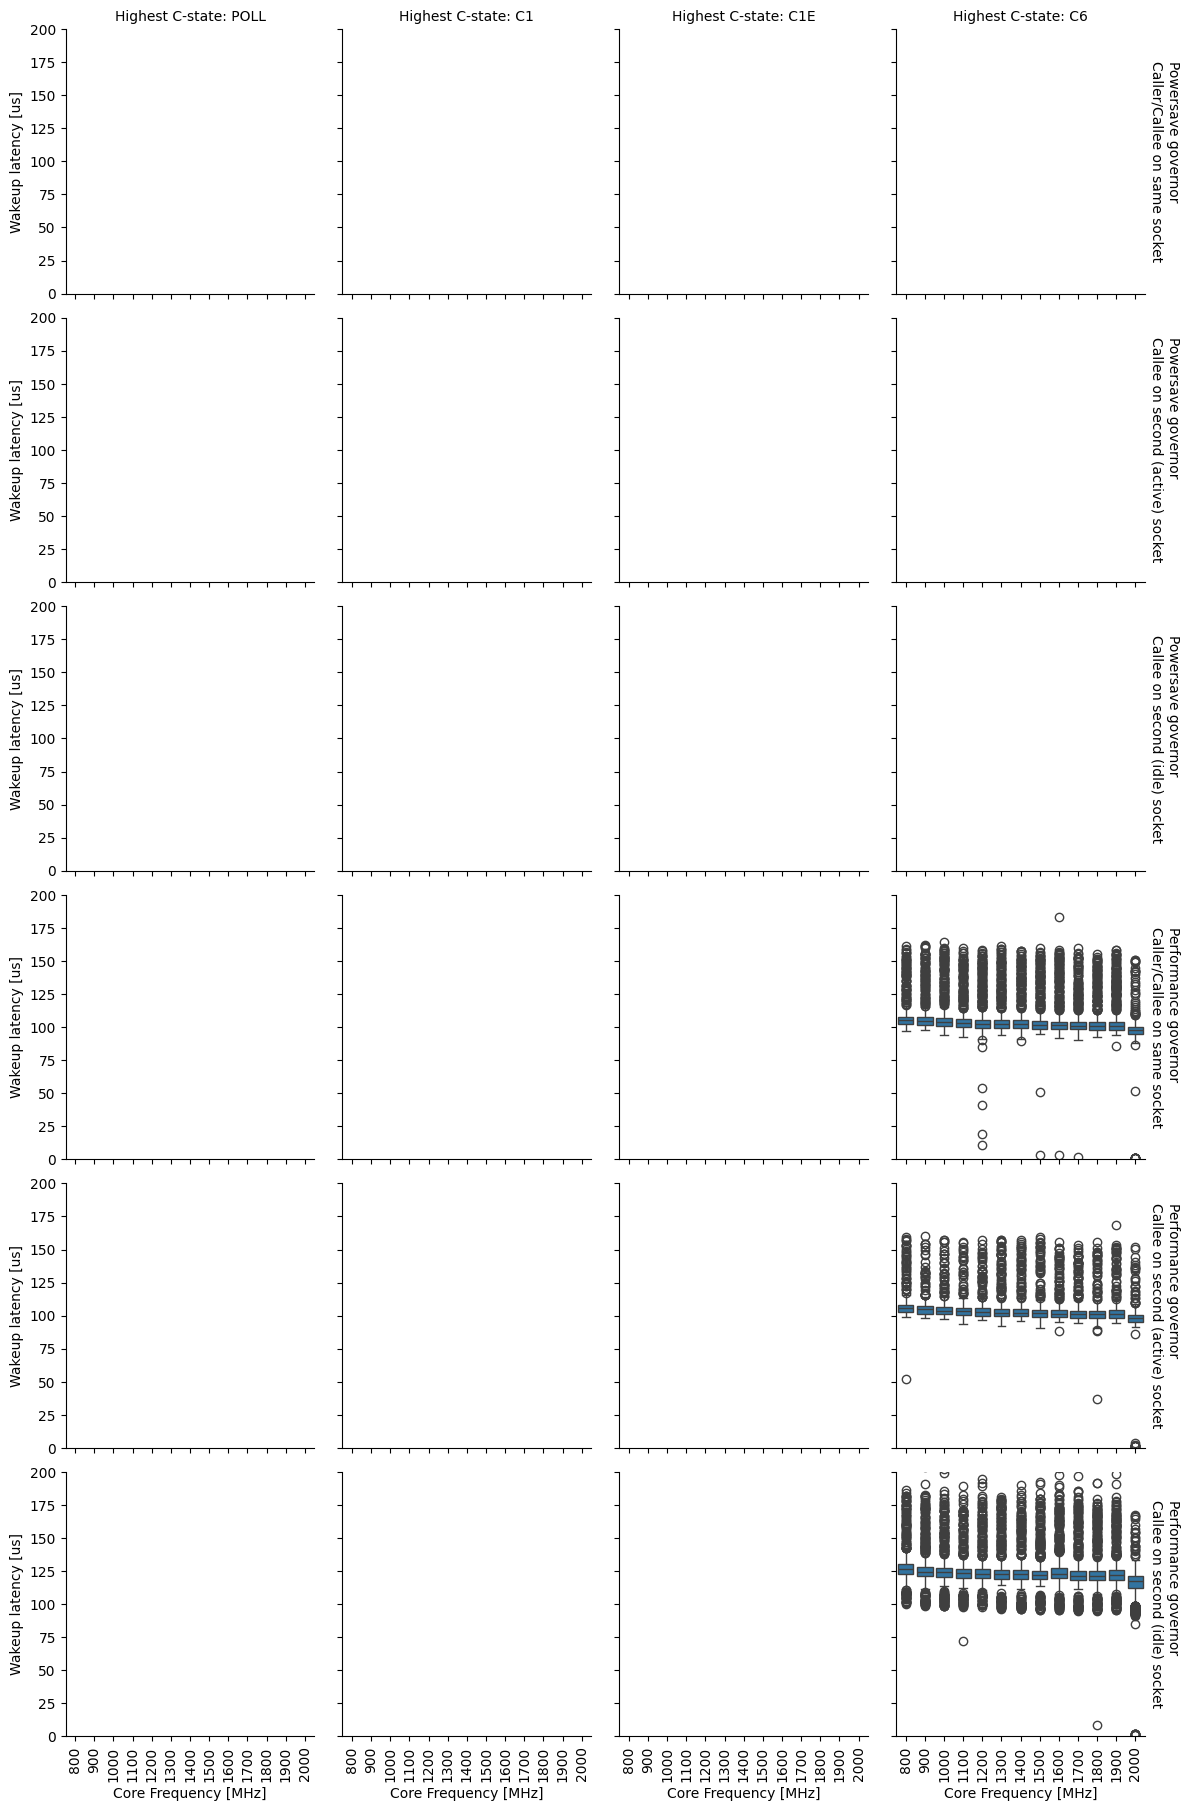

In [71]:
cstate_map = {
    0: "POLL",
    1: "C1",
    2: "C1E",
    3: "C6"
}
locality_map = {
    "powersave_local": "Powersave governor\nCaller/Callee on same socket",
    "powersave_remote_active": "Powersave governor\nCallee on second (active) socket",
    "powersave_remote_idle": "Powersave governor\nCallee on second (idle) socket",
    "performance_local": "Performance governor\nCaller/Callee on same socket",
    "performance_remote_active": "Performance governor\nCallee on second (active) socket",
    "performance_remote_idle": "Performance governor\nCallee on second (idle) socket",
}

df[LATENCY] = df["wakeup latency us"]
df[FREQUENCY] = (df["frequency"] / 1000).astype(int)
df[MAX_CSTATE] = df["state"].map(cstate_map)
df[SETTING] = df["locality"].map(locality_map)

g = sns.FacetGrid(df, col=MAX_CSTATE,  row=SETTING, col_order = cstate_map.values(), row_order=locality_map.values(), margin_titles=True)
g.map(sns.boxplot, FREQUENCY, LATENCY)
g.set(ylim=(0, 200))
g.set_titles(col_template="Highest C-state: {col_name}", row_template="{row_name}")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# savefig("../../../thesis/fig/C_state_latencies")

/home/marenz/de/tu-dresden/zih/roco2/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


saving  ../../../thesis/fig/C_state_latencies.eps


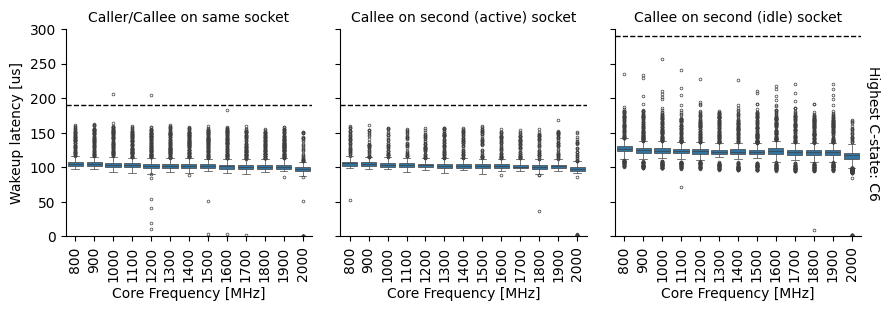

In [ ]:
cstate_map = {
    # 0: "POLL",
    # 1: "C1",
    # 2: "C1E",
    3: "C6"
}
locality_map = {
    # "powersave_local": "Powersave governor\nCaller/Callee on same socket",
    # "powersave_remote_active": "Powersave governor\nCallee on second (active) socket",
    # "powersave_remote_idle": "Powersave governor\nCallee on second (idle) socket",
    "performance_local": "Caller/Callee on same socket",
    "performance_remote_active": "Callee on second (active) socket",
    "performance_remote_idle": "Callee on second (idle) socket",
}

df[LATENCY] = df["wakeup latency us"]
df[FREQUENCY] = (df["frequency"] / 1000).astype(int)
df[MAX_CSTATE] = df["state"].map(cstate_map)
df[SETTING] = df["locality"].map(locality_map)

g = sns.FacetGrid(df, col=SETTING,  row=MAX_CSTATE, col_order = locality_map.values(), row_order=cstate_map.values(), margin_titles=True)
g.map(sns.boxplot, FREQUENCY, LATENCY, linewidth=.5, flierprops={"marker": "o", "markersize": 2, "markeredgewidth": 0.5})
g.set(ylim=(0, 300))
g.set_titles(col_template="{col_name}", row_template="Highest C-state: {row_name}")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# spr_cstates[2] in https://github.com/torvalds/linux/blob/master/drivers/idle/intel_idle.c
for (row_val, col_val), ax in g.axes_dict.items():
    if col_val == locality_map["performance_remote_idle"]:
        ax.axhline(y=290, color='black', linestyle='--', lw=1)
    else:
        ax.axhline(y=190, color='black', linestyle='--', lw=1)

# savefig("../../../thesis/fig/C_state_latencies")